In [2]:
import numpy as np
import scipy.special as sp
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from common import numerical_recipes as numrec
from common.baseclasses import ArrayWithAxes as AWA
from IPython.display import HTML

%matplotlib notebook

In [3]:
class BesselGenerator(object):

    """
    Generator of Bessel functions placed at arbitrary "center" position
    within an xy mesh space.  Works by generating a bessel function on
    a much larger xy mesh and then translating/truncating to the
    original mesh.  Nothing fancy, but good for performance.
    """

    def __init__(self,q=20,\
                 xs=np.linspace(-1,1,101),\
                 ys=np.linspace(-1,1,101),\
                 N_tip_eigenbasis = 10):

        #Bookkeeping of the coordinate mesh
        self.xs,self.ys=xs,ys
        self.shape=(len(xs),len(ys))
        self.midx=self.xs[self.shape[0]//2]
        self.midy=self.ys[self.shape[1]//2]
        self.dx=np.max(self.xs)-np.min(self.xs)
        self.dy=np.max(self.ys)-np.min(self.ys)

        #Make a mesh grid twice bigger in each direction
        bigshape=[2*N-1 for N in self.shape]
        xs2grid,ys2grid=np.ogrid[-self.dx:+self.dx:bigshape[0]*1j,
                                 -self.dy:+self.dy:bigshape[1]*1j]
        self.xs2=xs2grid.squeeze()
        self.ys2=ys2grid.squeeze()

        #J_zeros = sp.jn_zeros(0,N_tip_eigenbasis) #@ASM2019.12.21
        rs2 = np.sqrt(xs2grid**2+ys2grid**2)
        #self.Jbasis = np.array([(2/sp.jv(1,J_zeros[n]))*sp.jv(0,J_zeros[n]*rs2) for n in range(N_tip_eigenbasis)])
        self.Jbasis = np.array([(2*q*(n+1)/(N_tip_eigenbasis+1))**2*np.exp(-2*(n+1)/(N_tip_eigenbasis+1))*sp.jv(0,(2*q*(n+1)/(N_tip_eigenbasis+1))*rs2) for n in range(N_tip_eigenbasis)]) #@ASM2019.12.21: here we're actually making some linearly independent basis set

        self.Jv = np.random.randint(0,high=5,size=N_tip_eigenbasis)

        self.Jm = np.array([u*self.Jbasis[i] for i,u in enumerate(self.Jv)])
        self.bigJ=np.sum(self.Jm,axis=0)

    def GetTipEigenbasis(self,x0,y0):

        #@ASM2019.12.21 There were previously some bugs here
        #The center of our function is presently (midx,midy)
        shift_by_dx=x0-self.midx
        shift_by_dy=y0-self.midy
        shift_by_nx=int(self.shape[0]*shift_by_dx/self.dx)
        shift_by_ny=int(self.shape[1]*shift_by_dy/self.dy)

        tip_eigenbasis = []
        for u in self.Jbasis:
            newJ=np.roll(np.roll(u,shift_by_nx,axis=0),\
                         shift_by_ny,axis=1)
            output = newJ[self.shape[0]//2:(3*self.shape[0])//2,\
                        self.shape[1]//2:(3*self.shape[1])//2]
            output/=np.sqrt(np.sum(output**2))
            tip_eigenbasis.append(output)
        return AWA(tip_eigenbasis,axes=[None,self.xs,self.ys])

    def __call__(self,x0,y0):

        #@ASM2019.12.21 There were previously some bugs here
        #The center of our function is presently (midx,midy)
        shift_by_dx=x0-self.midx
        shift_by_dy=y0-self.midy
        shift_by_nx=int(self.shape[0]*shift_by_dx/self.dx)
        shift_by_ny=int(self.shape[1]*shift_by_dy/self.dy)

        newJ=np.roll(np.roll(self.bigJ,shift_by_nx,axis=0),\
                     shift_by_ny,axis=1)
        output = newJ[self.shape[0]//2:(3*self.shape[0])//2,\
                     self.shape[1]//2:(3*self.shape[1])//2]
        return AWA(output,axes=[self.xs,self.ys])


In [4]:
gen = BesselGenerator()

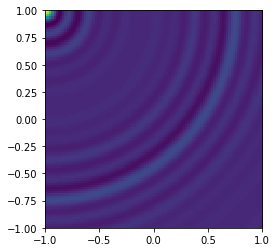

In [7]:
x0,y0 = -1,-1
curr = gen(x0,y0)
extent=[curr.axes[0].min(),curr.axes[1].max(),curr.axes[1].min(),curr.axes[1].max()]
fig = plt.figure()
im = plt.imshow(curr, extent=extent)

# initialization function: plot the background of each frame
def init():
    im.set_data(curr)
    return [im]

# animation function.  This is called sequentially
def animate(i):
    x0 = (i/100)%1-1
    im.set_array(gen(x0,y0))
    return [im]

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=1000, interval=1, blit=)


#HTML(anim.to_html5_video())



<IPython.core.display.Javascript object>


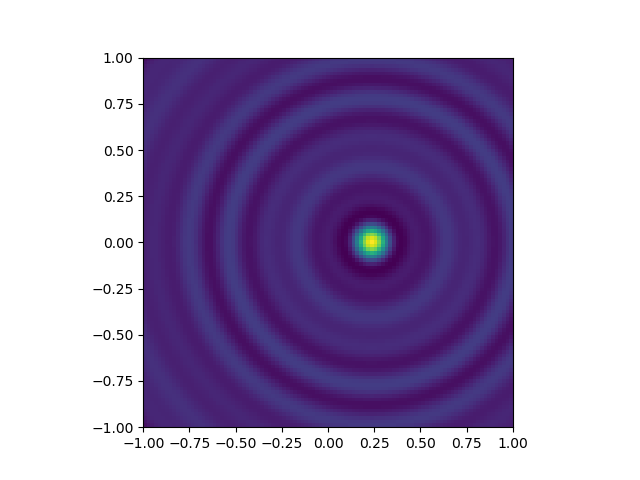